# Three Qubit Quantum Autoencoder

From https://github.com/lockwo/quantum_computation/blob/6d2c73ff9ac129478e82e8ddcfed41cdcd7b83b9/TFQ/QAE/quantum_autoencoder.py#L19

In [ ]:
!pip install cirq

In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install tensorflow-quantum

In [1]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [2]:
import tensorflow_quantum as tfq
import cirq 
import sympy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from itertools import product

In [3]:
# Right now states  are |0>L and |1>L (TODO add |+> and |-> => Just train on |-> as paper suggested)
def getValidStates(qubits, refQubits):
    return [ #|0>L
            { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            }, 
            { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            }, 
            { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])],
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            },
            { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])],
              'refcircuit': [cirq.I(refQubits[0]), cirq.I(refQubits[1]), cirq.I(refQubits[2])] 
            },
            # |1>L
            { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])],
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])] 
            },
            { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])], 
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])], 
              'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            },
            { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])], 
             'refcircuit': [cirq.X(refQubits[0]), cirq.X(refQubits[1]), cirq.X(refQubits[2])]
            }
          ] 

def generate_data(qubits, refQubits):
    """Generate training and testing data."""
    validStates = getValidStates(qubits, refQubits)
    n_rounds = 100
    states = []
    refStates = []
    rng = np.random.default_rng()
    for n in range(n_rounds):
      circuit = cirq.Circuit()
      refCircuit = cirq.Circuit()
      indx = rng.integers(0, len(validStates), size=1)[0]
      theState = validStates[indx]['circuit']
      theRef = validStates[indx]['refcircuit']
      for op in theState:
        circuit.append(op)
      for refOp in theRef:
        refCircuit.append(refOp)
      states.append(circuit)
      refStates.append(refCircuit)

    return states, refStates

12
Epoch 1/100
9/9 [==============================] - 5s 385ms/step - loss: 0.8216 - custom_accuracy: 1.0000 - val_loss: 0.7114 - val_custom_accuracy: 1.0000
Epoch 2/100
9/9 [==============================] - 2s 255ms/step - loss: 0.6311 - custom_accuracy: 1.0000 - val_loss: 0.6145 - val_custom_accuracy: 1.0000
Epoch 3/100
9/9 [==============================] - 2s 247ms/step - loss: 0.5179 - custom_accuracy: 1.0000 - val_loss: 0.4239 - val_custom_accuracy: 1.0000
Epoch 4/100
9/9 [==============================] - 2s 233ms/step - loss: 0.2793 - custom_accuracy: 1.0000 - val_loss: 0.1762 - val_custom_accuracy: 1.0000
Epoch 5/100
9/9 [==============================] - 2s 264ms/step - loss: 0.1940 - custom_accuracy: 1.0000 - val_loss: 0.2291 - val_custom_accuracy: 1.0000
Epoch 6/100
9/9 [==============================] - 2s 252ms/step - loss: 0.1733 - custom_accuracy: 1.0000 - val_loss: 0.1476 - val_custom_accuracy: 1.0000
Epoch 7/100
9/9 [==============================] - 2s 277ms/step - 

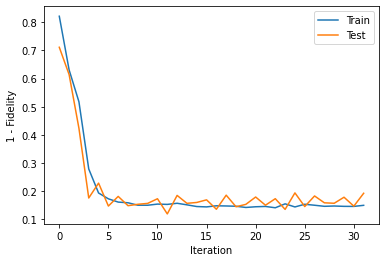

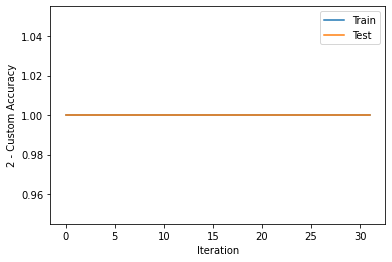

<Figure size 432x288 with 0 Axes>

In [5]:
def layer(qs, params):
    circ = cirq.Circuit()
    for i in reversed(range(len(qs)-1)):
        circ += cirq.CNOT(qs[i], qs[i+1])
    for i in range(len(qs)):
        circ += cirq.ry(params[2*i]).on(qs[i])
        circ += cirq.rz(params[2*i + 1]).on(qs[i])
    return circ

def make_circuit(qs, state, latent, params, depth, swap_qubit, reference_qubits):
    c = cirq.Circuit()
    enc_params = params[:len(params) // 2]
    dec_params = params[len(params) // 2:]
    for i in range(depth):
        c += layer(qs[:state], enc_params[2 * i * state:2 * (i + 1) * state])
    for i in range(depth):
        c += layer(qs[state - latent:], dec_params[2 * i * state:2 * (i + 1) * state])
    # SWAP Test
    c += cirq.H(swap_qubit)
    for i, j in product(range(state), range(state - latent, len(qs))):
        c += cirq.ControlledGate(sub_gate=cirq.SWAP, num_controls=1).on(swap_qubit, reference_qubits[i], qs[j])
    c += cirq.H(swap_qubit)
    return c

# Custom accuracy metric.
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

state_qubits = 4
latent_qubits = 1
total_qubits = state_qubits + (state_qubits - latent_qubits)

qubits = [cirq.GridQubit(0, i) for i in range(total_qubits + 1 + state_qubits)]
print(len(qubits))
states, reference_states = generate_data(qubits[:state_qubits], qubits[total_qubits + 1:])
states = list(states)
reference_states = list(reference_states)
temp = list(zip(states, reference_states))
random.shuffle(temp)
states, reference_states = zip(*temp)

layers = 4

num_params = 4 * state_qubits * layers
parameters = sympy.symbols("q0:%d"%num_params)

train_size = 9 * len(states) // 10
test_size = len(states) - train_size
training_states = states[:train_size]
testing_states = states[train_size:]
reference_states_train = reference_states[:train_size]
reference_states_test = reference_states[train_size:]
train_circuits = [training_states[i]  + reference_states_train[i] for i in range(train_size)]
test_circuits = [testing_states[i] + reference_states_test[i] for i in range(test_size)]
#print(make_circuit(qubits[:total_qubits], state_qubits, latent_qubits, parameters, layers, qubits[total_qubits], qubits[total_qubits + 1:]))
#print(training_states[0]  + reference_states[0] + make_circuit(qubits[:total_qubits], state_qubits, latent_qubits, parameters, layers, qubits[total_qubits], qubits[total_qubits + 1:]))
#print(train_circuits[0])
#print(training_states[0])
c = make_circuit(qubits[:total_qubits], state_qubits, latent_qubits, parameters, layers, qubits[total_qubits], qubits[total_qubits + 1:])
#print(c)
readout_operators = [cirq.Z(qubits[total_qubits])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
layer1 = tfq.layers.PQC(c, readout_operators, differentiator=tfq.differentiators.Adjoint())(inputs)
autoencoder = tf.keras.models.Model(inputs=inputs, outputs=layer1)
autoencoder.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=[custom_accuracy])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

X_train = tfq.convert_to_tensor(train_circuits)
X_test = tfq.convert_to_tensor(test_circuits)

y_train = np.ones(shape=len(train_circuits))
y_test = np.ones(shape=len(test_circuits))

history = autoencoder.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), callbacks=[callback])

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("1 - Fidelity")
plt.show()
plt.savefig("loss_comp")

plt.plot(history.history['custom_accuracy'], label='Train')
plt.plot(history.history['val_custom_accuracy'], label='Test')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("2 - Custom Accuracy")
plt.show()
plt.savefig("custom_accuracy")